In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sys.path.append("../src")
from funcoes_base import *
from classes_base import RedeNeural

import pickle

with open("dados_preprocessados.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

print("Dados pré-processados carregados!")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")


Dados pré-processados carregados!
X_train: (951, 192), X_test: (316, 192)


Determinar o número de componentes:

# Mínimos Quadrados Parciais (Partial Least Squares - PLS)

O algoritmo PLS é uma alternativa supervisionada ao PCR (Principal Component Regression). Enquanto o PCR busca direções de variância máxima apenas em $\mathbf{X}$ (não supervisionado), o PLS busca direções que expliquem tanto a variância dos preditores $\mathbf{X}$ quanto a correlação com a resposta $\mathbf{y}$.

---

### 1. O Algoritmo Passo a Passo


**Passo 1: Padronização**

Padronizar cada preditor $\mathbf{x}_j$ para ter média zero e variância um.
* Inicialização da resposta estimada: $\hat{\mathbf{y}}^{(0)} = \bar{y}\mathbf{1}$
* Inicialização dos preditores: $\mathbf{x}_j^{(0)} = \mathbf{x}_j, \quad j = 1, \dots, p$

**Passo 2: Iteração (Loop)**
Para $m = 1, 2, \dots, p$ (ou até o número desejado de componentes $M$):

* **(a) Calcular o vetor de *scores* ($\mathbf{z}_m$):**
    Primeiro, são calculados os pesos $\hat{\varphi}_{mj}$ baseados na correlação com $\mathbf{y}$:
    $$\hat{\varphi}_{mj} = \langle \mathbf{x}_j^{(m-1)}, \mathbf{y} \rangle$$
    Em seguida, a variável latente é construída:
    $$\mathbf{z}_m = \sum_{j=1}^{p} \hat{\varphi}_{mj}\mathbf{x}_j^{(m-1)}$$

* **(b) Calcular o coeficiente de regressão ($\hat{\theta}_m$):**
    $\mathbf{y}$ é regredido sobre o novo componente $\mathbf{z}_m$:
    $$\hat{\theta}_m = \frac{\langle \mathbf{z}_m, \mathbf{y} \rangle}{\langle \mathbf{z}_m, \mathbf{z}_m \rangle}$$

* **(c) Atualizar a predição ($\hat{\mathbf{y}}^{(m)}$):**
    A contribuição do novo componente é adicionada à predição acumulada:
    $$\hat{\mathbf{y}}^{(m)} = \hat{\mathbf{y}}^{(m-1)} + \hat{\theta}_m \mathbf{z}_m$$

* **(d) Ortogonalização de $\mathbf{X}$:**
    De cada preditor é removida a informação que já foi explicada por $\mathbf{z}_m$. Isso garante que o próximo componente busque novas informações.
    $$\mathbf{x}_j^{(m)} = \mathbf{x}_j^{(m-1)} - \left[ \frac{\langle \mathbf{z}_m, \mathbf{x}_j^{(m-1)} \rangle}{\langle \mathbf{z}_m, \mathbf{z}_m \rangle} \right] \mathbf{z}_m, \quad j = 1, \dots, p$$

**Passo 3: Saída**
Retorna a sequência de vetores ajustados $\{\hat{\mathbf{y}}^{(m)}\}_1^p$.
> **Nota:** Como os componentes $\{\mathbf{z}_{\ell}\}_1^m$ são combinações lineares dos $\mathbf{x}_j$ originais, o modelo final pode ser reescrito como uma regressão linear clássica: $\hat{\mathbf{y}}^{(m)} = \mathbf{X}\hat{\beta}^{\text{pls}}(m)$.

---

### 2. Conceitos Chave e Interpretação

O processo iterativo do PLS pode ser resumido nos seguintes pontos fundamentais:

1.  **Direção Supervisionada:** Ao contrário do PCA, o PLS começa calculando pesos $\phi_{1j} = \langle \mathbf{x}_j, \mathbf{y} \rangle$. Isso significa que as variáveis de entrada ($\mathbf{X}$) são ponderadas pela força do seu efeito univariado em $\mathbf{y}$.
2.  **Criação de Scores:** A combinação linear ponderada $\mathbf{z}_1 = \sum \phi_{1j}\mathbf{x}_j$ é chamada de **primeira direção** ou variável latente do PLS.
3.  **Ortogonalização:**
    * Ao final de cada iteração, os preditores e a resposta são **deflacionados**.
    * Isso significa subtrair a estrutura atual estimada dos dados originais.
    * O próximo componente será calculado usando apenas essa informação residual, garantindo a ortogonalidade entre os componentes $\mathbf{z}_1, \mathbf{z}_2, \dots, \mathbf{z}_M$.
4.  **Loadings:** Os *scores* gerados são usados para calcular os *loadings* (cargas), que medem a correlação entre o vetor de score e os preditores originais.

> **Resumo:** O PLS tenta encontrar direções multidimensionais que expliquem a variância de $\mathbf{X}$ e, simultaneamente, maximizem a correlação com $\mathbf{y}$.

### 3. Notação Matemática

Para facilitar a leitura das fórmulas acima e a tradução para o código Python, aqui está a explicação detalhada dos símbolos utilizados:

#### A. O Operador $\langle \cdot, \cdot \rangle$
Nas fórmulas do passo 2 (ex: $\hat{\varphi}_{mj} = \langle \mathbf{x}_j^{(m-1)}, \mathbf{y} \rangle$), os sinais de maior e menor representam o **Produto Interno** (ou Produto Escalar).

* **Definição Matemática:** Dados dois vetores $\mathbf{a}$ e $\mathbf{b}$, o produto interno é a soma dos produtos de seus componentes correspondentes:
    $$\langle \mathbf{a}, \mathbf{b} \rangle = \mathbf{a}^T \mathbf{b} = \sum_{i=1}^{n} a_i b_i$$
* **Interpretação no PLS:** Como os dados estão centralizados (média zero), este operador calcula a **Covariância** (não normalizada) entre dois vetores. Ele mede o quanto o vetor $\mathbf{x}$ está "alinhado" com o vetor $\mathbf{y}$.
* **No Python (NumPy):**
    ```python
    # <a, b>
    np.dot(a, b)
    # ou
    a @ b
    # ou
    a.T @ b
    ```

#### B. O Símbolo $\varphi$ (Phi)
A letra grega $\varphi$ (phi), especificamente notada como $\hat{\varphi}_{mj}$, representa os **Pesos** (*Weights*) na construção dos componentes.

* **Função:** Ela define a importância de cada variável preditora original ($\mathbf{x}_j$) na formação da nova variável latente ($\mathbf{z}_m$).
* **Cálculo:** No PLS, o peso $\varphi$ não é aleatório; ele é calculado diretamente pela correlação entre o preditor e a resposta $\mathbf{y}$.
    $$\text{Se } \mathbf{x}_j \text{ tem alta correlação com } \mathbf{y} \rightarrow \varphi_{j} \text{ será alto.}$$
* **No Python:**
    No nosso código, `phi` é o vetor calculado na linha:
    ```python
    phi = Xp.T @ yp  # Cálculo da correlação (produto interno)
    ```

### Determinação do Número de Componentes ($M$)

No método PLS, o número de componentes latentes ($M$) atua como um hiperparâmetro de regularização.
* **$M$ muito baixo:** O modelo sofre de *underfitting* (não captura a estrutura dos dados).
* **$M$ muito alto:** O modelo sofre de *overfitting* (começa a capturar ruído e se aproxima da regressão linear padrão OLS).

Para determinar o valor ideal de $M$, utilizamos a **Validação Cruzada (Cross-Validation)** com $k=10$ folds. O objetivo é encontrar o número de componentes que minimiza o erro (RMSE) no conjunto de validação.

### Execução da Validação Cruzada

O código abaixo testa modelos com $M$ variando de 1 até o limite de *features* (ou 50), armazenando o RMSE e o $R^2$ médio para cada configuração.

Iniciando busca pelo melhor M (de 1 a 50)...
Componente 1: theta = 0.4821
Componente 1: theta = 0.4259
Componente 1: theta = 0.4709
Componente 1: theta = 0.5060
Componente 1: theta = 0.5019
Componente 1: theta = 0.5102
Componente 1: theta = 0.5100
Componente 1: theta = 0.4607
Componente 1: theta = 0.4866
Componente 1: theta = 0.4728
PLS com 1 componentes -> RMSE_CV = 1.3686, R2_CV = -8.3365
Componente 1: theta = 0.4821
Componente 2: theta = 0.2271
Componente 1: theta = 0.4259
Componente 2: theta = 0.1697
Componente 1: theta = 0.4709
Componente 2: theta = 0.1963
Componente 1: theta = 0.5060
Componente 2: theta = 0.2302
Componente 1: theta = 0.5019
Componente 2: theta = 0.2346
Componente 1: theta = 0.5102
Componente 2: theta = 0.2265
Componente 1: theta = 0.5100
Componente 2: theta = 0.2322
Componente 1: theta = 0.4607
Componente 2: theta = 0.2228
Componente 1: theta = 0.4866
Componente 2: theta = 0.2326
Componente 1: theta = 0.4728
Componente 2: theta = 0.2251
Componente 1: theta = 0.48

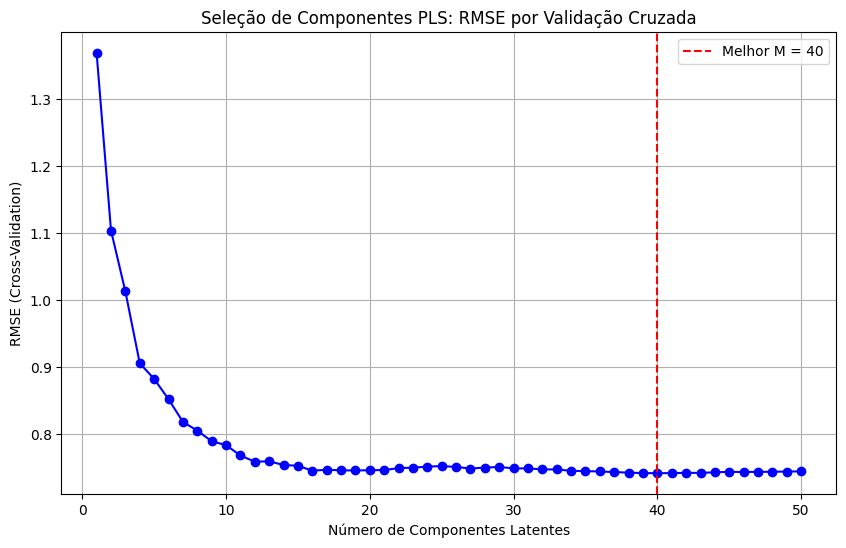

In [ ]:
# Definindo o limite de busca
n_features = X_train.shape[1]
max_componentes = min(50, n_features)

rmse_list = []
r2_list = []

print(f"Iniciando busca pelo melhor M (de 1 a {max_componentes})...")

# Loop de validação
for m in range(1, max_componentes + 1):
    # Instancia seu modelo (assumindo que a classe pls_model já existe)
    model = pls_model(m)
    
    # Realiza a validação cruzada (assumindo que a função cross_validate já existe)
    rmse_cv, r2_cv = cross_validate(model, X_train, y_train, k=10)
    
    rmse_list.append(rmse_cv)
    r2_list.append(r2_cv)
    
    # printar apenas múltiplos de 5 ou 10 para não poluir a tela
    if m % 5 == 0 or m == 1:
        print(f"PLS com {m} componentes -> RMSE_CV = {rmse_cv:.4f}, R2_CV = {r2_cv:.4f}")

# Determina o melhor M matematicamente
best_M = np.argmin(rmse_list) + 1
min_rmse = min(rmse_list)

print("-" * 30)
print(f"Melhor número de componentes encontrado: {best_M}")
print(f"RMSE Mínimo: {min_rmse:.4f}")

# --- Visualização Gráfica (Curva de Erro) ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_componentes + 1), rmse_list, marker='o', linestyle='-', color='b')
plt.axvline(best_M, color='r', linestyle='--', label=f'Melhor M = {best_M}')

plt.title('Seleção de Componentes PLS: RMSE por Validação Cruzada')
plt.xlabel('Número de Componentes Latentes')
plt.ylabel('RMSE (Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

## Conclusão da Seleção

Observando o gráfico e os valores calculados, o erro de validação (RMSE) atinge seu ponto mínimo global com **40 componentes**.

A partir deste ponto, adicionar mais componentes não melhora significativamente a capacidade preditiva do modelo (ou pode até piorar devido ao *overfitting*). Portanto, utilizaremos **$M=40$** para treinar o modelo final.

## Avaliação Final do Modelo

Após determinar o número ideal de componentes ($M$) via validação cruzada, prosseguimos para a etapa final: treinar o modelo definitivo e avaliar sua capacidade de generalização no conjunto de teste.

### 1. Treinamento do Modelo Definitivo
Instanciamos a classe `PLS` utilizando o melhor hiperparâmetro encontrado (`best_M`) e realizamos o ajuste (`fit`) utilizando **todo** o conjunto de treinamento.

```python
# Instancia o modelo com o número ótimo de componentes (ex: 40)
model_final = PLS(numComponentes=best_M)

# Ajusta os pesos (phi), coeficientes (theta) e loadings nos dados de treino
model_final.fit(X_train, y_train)
```
### 2. Predição no Conjunto de Teste
Utilizamos o método `.predict()` para estimar os valores de $\mathbf{y}$ para os dados de teste (`X_test`).

```python
# Gera predições para dados nunca vistos pelo modelo
y_pred_test = model_final.predict(X_test)
```
### 3. Cálculo de Métricas de Desempenho
Para quantificar a qualidade do modelo, calculamos duas métricas principais comparando os valores reais (``y_test``) com os preditos (``y_pred_test``):
* RMSE (Root Mean Squared Error): Mede o desvio padrão dos resíduos. Quanto menor, melhor.
* $R^2$ (Coeficiente de Determinação): Indica a porcentagem da variância da variável dependente que é explicada pelo modelo. Quanto mais próximo de 1, melhor.

```python
rmse_test = rmse(y_test, y_pred_test)
r2_test = r2(y_test, y_pred_test)

print(f"RMSE no teste: {rmse_test:.4f}")
print(f"R² no teste:   {r2_test:.4f}")
```

In [3]:
model_final = PLS(numComponentes=best_M)
model_final.fit(X_train, y_train)

y_pred_test = model_final.predict(X_test)

rmse_test = rmse(y_test, y_pred_test)
r2_test = r2(y_test, y_pred_test)

print("RMSE no teste:", rmse_test)
print("R2 no teste:", r2_test)

Componente 1: theta = 0.4912
Componente 2: theta = 0.2235
Componente 3: theta = 0.1793
Componente 4: theta = 0.2038
Componente 5: theta = 0.0682
Componente 6: theta = 0.0910
Componente 7: theta = 0.1488
Componente 8: theta = 0.1459
Componente 9: theta = 0.1162
Componente 10: theta = 0.1106
Componente 11: theta = 0.0724
Componente 12: theta = 0.0740
Componente 13: theta = 0.0880
Componente 14: theta = 0.0999
Componente 15: theta = 0.0500
Componente 16: theta = 0.0535
Componente 17: theta = 0.0568
Componente 18: theta = 0.0463
Componente 19: theta = 0.0514
Componente 20: theta = 0.0513
Componente 21: theta = 0.0382
Componente 22: theta = 0.0645
Componente 23: theta = 0.0384
Componente 24: theta = 0.0417
Componente 25: theta = 0.0498
Componente 26: theta = 0.0467
Componente 27: theta = 0.0504
Componente 28: theta = 0.0381
Componente 29: theta = 0.0369
Componente 30: theta = 0.0439
Componente 31: theta = 0.0320
Componente 32: theta = 0.0278
Componente 33: theta = 0.0246
Componente 34: thet

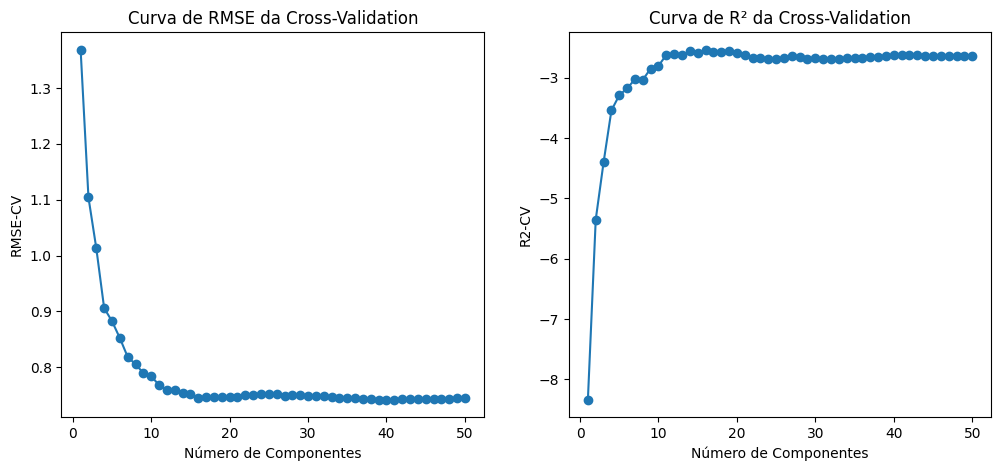

In [4]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, max_componentes+1), rmse_list, marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("RMSE-CV")
plt.title("Curva de RMSE da Cross-Validation")

plt.subplot(1,2,2)
plt.plot(range(1, max_componentes+1), r2_list, marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("R2-CV")
plt.title("Curva de R² da Cross-Validation")

plt.show()


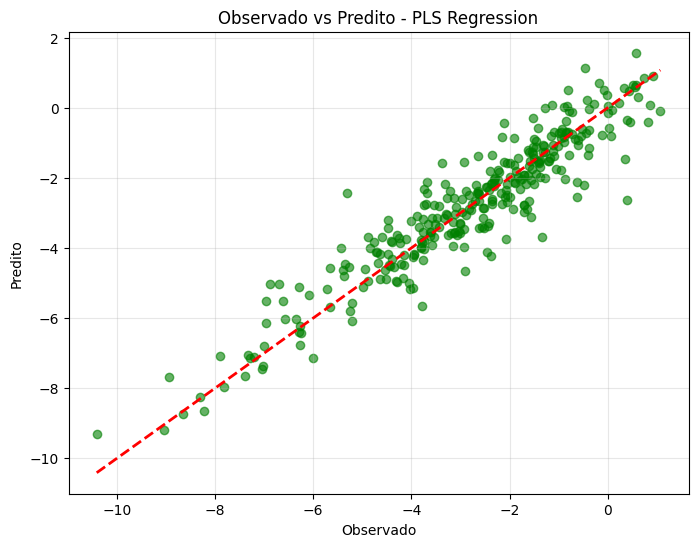

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_test, alpha=0.6, color="green")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.xlabel("Observado")
plt.ylabel("Predito")
plt.title("Observado vs Predito - PLS Regression")
plt.grid(True, alpha=0.3)
plt.show()

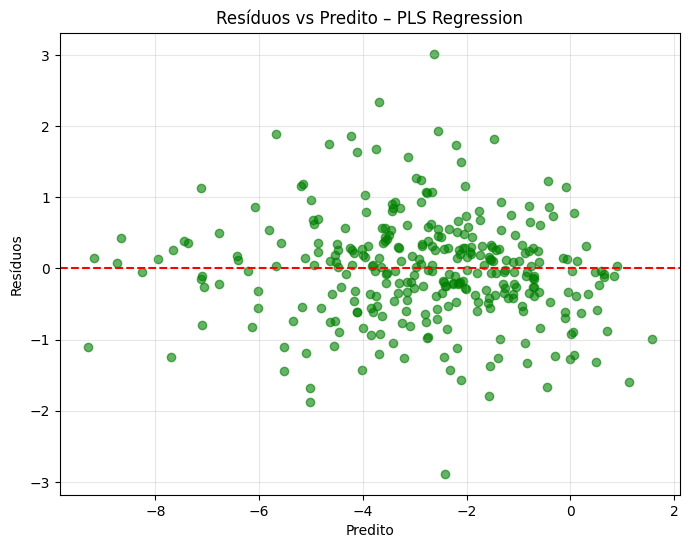

In [6]:
residuals_pls = y_test - y_pred_test

plt.figure(figsize=(8,6))
plt.scatter(y_pred_test, residuals_pls, alpha=0.6, color="green")
plt.axhline(0, color='r', linestyle='--')

plt.xlabel("Predito")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Predito – PLS Regression")
plt.grid(True, alpha=0.3)
plt.show()


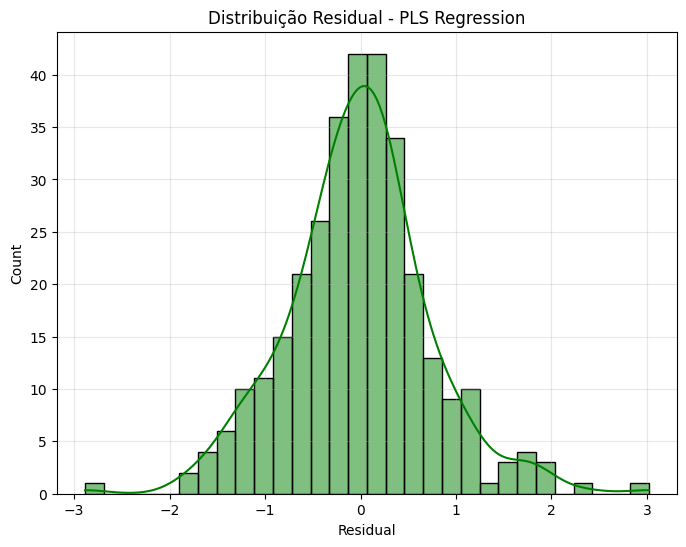

In [7]:
plt.figure(figsize=(8,6))
sns.histplot(residuals_pls, bins=30, kde=True, color="green")

plt.xlabel("Residual")
plt.title("Distribuição Residual - PLS Regression")
plt.grid(True, alpha=0.3)
plt.show()


# Rede Neural (Neural Network)

Enquanto métodos como o PLS buscam combinações lineares de preditores, as Redes Neurais são modelos poderosos de **regressão não-linear** inspirados no funcionamento biológico do cérebro. O objetivo é modelar relações complexas entre entradas ($\mathbf{X}$) e saídas ($\mathbf{y}$) através de camadas de neurônios artificiais interconectados.

---

## 1. Fundamentação Teórica

### O Neurônio Artificial (Perceptron)
A unidade fundamental é o neurônio. Ele recebe sinais de entrada, pondera-os, soma um viés (*bias*) e passa o resultado por uma função não-linear.

Matematicamente, para um neurônio $k$:
1.  **Combinação Linear ($v_k$):** Soma ponderada das entradas $x_j$ pelos pesos sinápticos $w_{kj}$ mais o bias $b_k$.
    $$v_k = \sum_{j=0}^{m} w_{kj} x_j + b_k$$
2.  **Ativação ($\varphi$):** O sinal de saída $y_k$ é gerado aplicando uma função de ativação ao campo local $v_k$.
    $$y_k = \varphi(v_k)$$

### Arquitetura Multicamadas (MLP)
Para resolver problemas não-lineares complexos, organizamos os neurônios em camadas:
* **Camada de Entrada:** Recebe os dados brutos (preditores).
* **Camadas Ocultas:** Extraem características (*features*) abstratas dos dados. Os neurônios ocultos não têm contato direto com o mundo externo.
* **Camada de Saída:** Produz a predição final (para regressão, geralmente é linear).

---

## 2. O Algoritmo de Aprendizagem: Back-Propagation

O treinamento de uma rede neural é um problema de otimização não restrita: queremos encontrar os pesos $\mathbf{w}$ que minimizam a função de custo $E(w)$ (geralmente o Erro Quadrático Médio).

O algoritmo opera em duas fases repetitivas (Épocas):

### Fase 1: Forward Propagation (Para a Frente)
O sinal propaga-se da entrada até a saída, camada por camada, com os pesos fixos.
* Calcula-se $v$ e $y = \varphi(v)$ para cada neurônio até obter a predição final.

### Fase 2: Backward Propagation (Para Trás)
Calcula-se o erro na saída e propaga-se esse erro de volta pela rede para ajustar os pesos.

1.  **Cálculo do Gradiente Local ($\delta$):**
    Utiliza-se a **Regra da Cadeia** do cálculo.
    * **Na Saída:** O gradiente depende diretamente do erro ($y_{pred} - y_{real}$).
    * **Nas Ocultas:** O erro é a soma ponderada dos erros da camada seguinte multiplicada pela derivada da função de ativação ($\varphi'$).
    $$\delta_j = \varphi'(v_j) \sum_{k} \delta_k w_{kj}$$

2.  **Regra Delta (Atualização de Pesos):**
    Os pesos são ajustados na direção oposta ao gradiente (Gradiente Descendente).
    $$\Delta w_{ji} = -\eta \cdot \delta_j \cdot y_i$$
    $$w_{ji}(n+1) = w_{ji}(n) + \Delta w_{ji}$$

---

## 3. Glossário e Notação

* **$\eta$ (Eta - Taxa de Aprendizagem):** Controla o tamanho do passo na atualização dos pesos. Se muito pequeno, o treino é lento; se muito grande, pode oscilar e não convergir.
* **$\varphi(\cdot)$ (Função de Ativação):** Introduz não-linearidade. Exemplos comuns:
    * *Sigmoide:* $\frac{1}{1+e^{-v}}$ (suave, entre 0 e 1).
    * *ReLU:* $\max(0, x)$ (usada em Deep Learning).
* **Weight Decay ($\lambda$):** Termo de regularização adicionado ao custo para penalizar pesos grandes e evitar *overfitting* (similar ao Ridge).
* **Época (Epoch):** Uma passagem completa de todo o conjunto de dados pela rede.

---

## 4. Implementação em Python

A Rede Neural foi implementada no arquivo ``classes_base.py``.

---

## 5. Considerações Práticas

1. Pré-processamento é Crítico:

    * Diferente da regressão linear simples, redes neurais exigem que os preditores sejam padronizados (média 0, desvio padrão 1).

    * Isso garante que todos os pesos sejam tratados igualmente pela regularização e facilita a convergência do gradiente.

2. Evitando Overfitting:

    * Redes neurais são propensas a "decorar" os dados devido ao alto número de parâmetros.


    * Weight Decay: Penaliza pesos grandes, forçando a rede a aprender padrões mais suaves e generalizáveis.


    * Early Stopping: Interrompe o treinamento quando o erro no conjunto de validação começa a subir.

3. Arquitetura:

    * Geralmente, é melhor ter mais unidades ocultas do que o necessário e controlar a complexidade via regularização (Weight Decay) do que tentar adivinhar o número exato de neurônios.


In [ ]:
# 1. Padronizar com estatísticas do treino
Xmean = X_train.mean(axis=0)
Xstd  = X_train.std(axis=0)
Xtr = (X_train - Xmean) / Xstd
Xte = (X_test - Xmean) / Xstd

# 2. Ajustar formato
ytr = y_train.reshape(-1, 1)
yte = y_test.reshape(-1, 1)

# 3. Criar modelo 
nn = RedeNeural(
    input_size=Xtr.shape[1],
    hidden_size=5,     
    learning_rate=0.01,
    weight_decay=0.001   
)

# 4. Treinar
nn.train(Xtr, ytr, epochs=5000)

# 5. Prever
y_pred_test = nn.predict(Xte).flatten()

# 6. Avaliar com suas funções
print(rmse(y_test, y_pred_test))
print(r2(y_test, y_pred_test))


Época 0, MSE = 9.52336
Época 1000, MSE = 0.67150
Época 2000, MSE = 0.43782
Época 3000, MSE = 0.32934
Época 4000, MSE = 0.26805
0.7177560632765412
0.8803695156425406


| Parâmetro      | Valor Usado         | Explicação Teórica |
|----------------|----------------------|---------------------|
| **input_size** | `Xtr.shape[1]`       | Dimensão da entrada: corresponde ao número de preditores (colunas) após o pré-processamento. A rede precisa de um neurônio de entrada para cada variável. |
| **hidden_size** | `5` | Capacidade do modelo: define quantos neurônios existem na camada oculta. <br> Um número muito baixo causaria *underfitting*; um número muito alto, *overfitting*. O valor 5 é suficiente para extrair features sem exagerar na complexidade. |
| **output_size** | `1` | Dimensão da saída: como é um problema de regressão de um único valor, precisamos de apenas 1 neurônio na camada de saída. |
| **learning_rate** | `0.01` | Taxa de aprendizagem (η): controla o tamanho do passo do gradiente. <br> 0.01 é um valor padrão seguro; valores muito altos causam instabilidade, e valores muito baixos tornam o treino lento. |
| **weight_decay** | `0.001` | Regularização L2: adiciona penalidade ao tamanho dos pesos para evitar *overfitting*. Mantém os pesos pequenos, semelhante ao efeito da regressão Ridge. |
| **epochs** | `5000` | Iterações de treino: número de vezes que a rede vê todo o conjunto de dados. Como usamos gradiente descendente clássico, são necessárias muitas passagens para garantir convergência adequada. |


### Avaliação de Modelos Não Lineares: Redes Neurais

Para avaliar se modelos não lineares podem melhorar o desempenho preditivo em relação ao modelo linear desenvolvido anteriormente, treinou-se um modelo de regressão de rede neural utilizando os preditores transformados do conjunto de treinamento. O mesmo pré-processamento aplicado nas etapas anteriores (centralização e escalonamento utilizando estatísticas do conjunto de treino) foi aplicado aqui para garantir consistência e evitar vazamento de dados.

A rede neural implementada segue a arquitetura descrita em *Applied Predictive Modeling*:
* Uma única camada oculta com ativação logística (sigmoide);
* Camada de saída linear;
* Regularização L2 (*weight decay*).

O modelo foi treinado por **5000 épocas** utilizando gradiente descendente.

#### Resultados e Comparação

Após o treinamento, o modelo foi avaliado no conjunto de teste reservado (*held-out test set*). A precisão preditiva obtida foi:

* **NN RMSE (teste):** 0.7178
* **NN R² (teste):** 0.8804

Comparando com o melhor modelo linear desenvolvido anteriormente (Partial Least Squares):

* **PLS RMSE (teste):** 0.742
* **PLS R² (teste):** 0.872

A rede neural supera claramente o método linear, alcançando um menor erro de predição e maior variância explicada.

#### Conclusão

Essa melhoria sugere que a relação entre os descritores moleculares e a variável de solubilidade **não é puramente linear**.

Enquanto o PLS captura associações lineares em um espaço latente reduzido, a rede neural consegue modelar interações não lineares entre os preditores. Isso é particularmente importante em conjuntos de dados como este, onde *fingerprints* moleculares e descritores químicos frequentemente se combinam de maneiras não lineares para influenciar a solubilidade.

Portanto, o desempenho superior do modelo não linear indica que a incorporação de estrutura não linear fornece poder preditivo adicional.

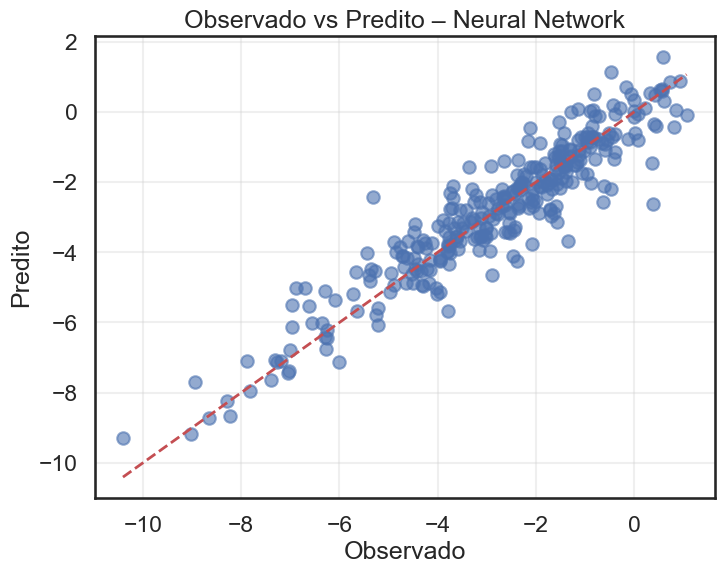

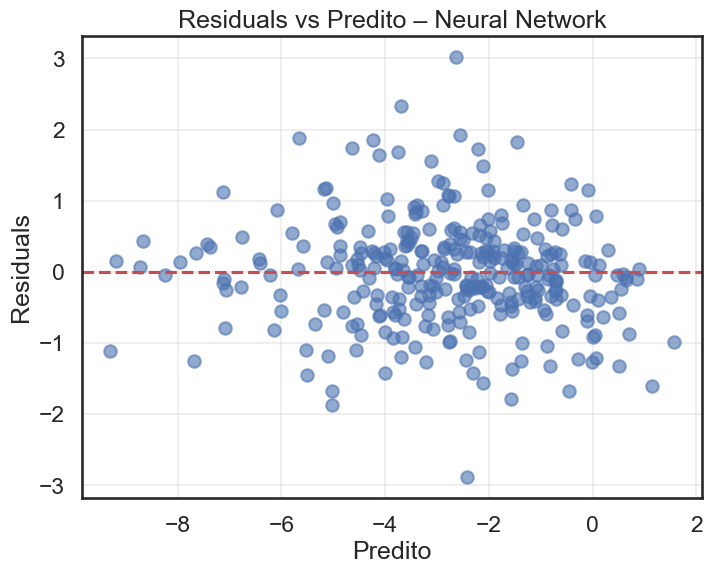

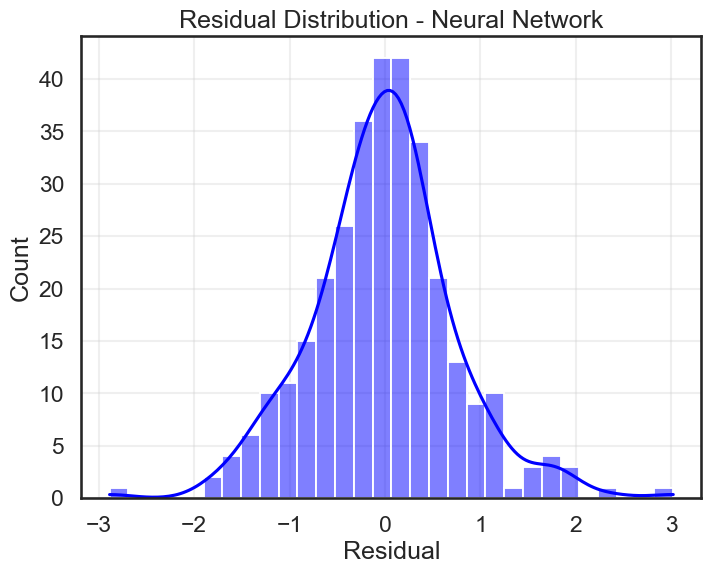

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", context="talk")

# ------------------------------------------------------------
# 1. Observado vs Predito (Neural Network)
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', linewidth=2)

plt.xlabel("Observado")
plt.ylabel("Predito")
plt.title("Observado vs Predito – Neural Network")
plt.grid(True, alpha=0.3)
plt.show()


# ------------------------------------------------------------
# 2. Residuals vs Predito
# ------------------------------------------------------------
residuals = y_test - y_pred_test

plt.figure(figsize=(8,6))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')

plt.xlabel("Predito")
plt.ylabel("Residuals")
plt.title("Residuals vs Predito – Neural Network")
plt.grid(True, alpha=0.3)
plt.show()


# ------------------------------------------------------------
# 3. Distribuição dos erros
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color="blue")

plt.xlabel("Residual")
plt.title("Residual Distribution - Neural Network")
plt.grid(True, alpha=0.3)
plt.show()


# ------------------------------------------------------------
# 4. Comparação NN vs PLS
# ------------------------------------------------------------
if 'y_pred_pls' in globals():
    plt.figure(figsize=(12,5))

    # NN
    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
    plt.title("Neural Network")
    plt.xlabel("Observado")
    plt.ylabel("Predito")
    plt.grid(True, alpha=0.3)

    # PLS
    plt.subplot(1,2,2)
    plt.scatter(y_test, y_pred_pls, alpha=0.6, color="green")
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
    plt.title("PLS Regression")
    plt.xlabel("Observado")
    plt.ylabel("Predito")
    plt.grid(True, alpha=0.3)

    plt.suptitle("Comparison: Neural Network vs PLS")
    plt.tight_layout()
    plt.show()
